**Table of contents**<a id='toc0_'></a>    
- [Data Mining Lab 2 - Phase 2](#toc1_)    
  - [Before Starting](#toc1_1_)    
  - [Introduction](#toc1_2_)    
  - [**1. Data Preparation**](#toc1_3_)    
  - [**1.1 Load data**](#toc1_4_)    
  - [**1.2 Strategy**](#toc1_2_)    
  - [**2. Large Language Models (LLMs)**](#toc1_5_)    
    - [Open-Source vs. Proprietary LLMs](#toc1_5_1_)    
    - [Why Use Code (API) for Data Mining?](#toc1_5_2_)    
    - [The Gemini API](#toc1_5_3_)    
    - [Interacting with the Gemini API](#toc1_5_4_)    
    - [**2.1 Text Prompting**](#toc1_5_5_)    
        - [**>>> Exercise 1 (Take home):**](#toc1_5_5_1_1_)    
    - [**2.2 Structured Output**](#toc1_5_6_)    
        - [**>>> Exercise 2 (Take home):**](#toc1_5_6_1_1_)    
    - [**2.3 Information Extraction and Grounding:**](#toc1_5_7_)    
      - [**`langextract`: A Library for Grounded Extraction**](#toc1_5_7_1_)    
        - [**2.3.1 Using PDF Documents:**](#toc1_5_7_1_1_)    
        - [**>>> Bonus Exercise 3 (Take home):**](#toc1_5_7_1_2_)    
    - [**2.4 Generating LLM Embeddings:**](#toc1_5_8_)    
        - [**>>> Exercise 4 (Take home):**](#toc1_5_8_1_1_)    
    - [**2.5 Retrieval-Augmented Generation (RAG)**](#toc1_5_9_)    
        - [**Actual answer in the URL:**](#toc1_5_9_1_1_)    
        - [**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc1_5_9_1_2_)    
        - [**>>> Bonus Exercise 5 (Take home):**](#toc1_5_9_1_3_)    
    - [**2.6 Few-Shot Prompting Classification:**](#toc1_5_10_)    
        - [**>>> Exercise 6 (Take home):**](#toc1_5_10_1_1_)    
        - [**>>> Exercise 7 (Take home):**](#toc1_5_10_1_2_)    
    - [**2.7 Extra LLM Related Materials:**](#toc1_5_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_3_'></a>[**1.1 Data Preparation**](#toc0_)

## <a id='toc1_5_'></a>[**1.1.1 Read data**](#toc0_)

In [52]:
import pandas as pd
import json

PATH = r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Competition\data\task-emotion-recognition"

# Flatten json data
with open(f"{PATH}/final_posts.json", "r", encoding="utf-8") as json_df:
    posts = json.load(json_df)
df_posts = pd.json_normalize(posts, sep="_")

# Organize & check json data
print("="*20,"Data df_posts","="*20)
print(df_posts.head(3))
print("="*20,"Columns of df_posts","="*20)
for col in df_posts.columns: print(col)
print("="*20,"Shape of df_posts","="*20)
print(df_posts.shape)
print("="*20,"Check the columns of df_posts","="*20)
df_empty_hashtags = df_posts[df_posts["root__source_post_hashtags"].apply(lambda x: len(x) == 0)]
print("Empty hashtag count:", len(df_empty_hashtags),"(",len(df_empty_hashtags)/len(df_posts),"%)")
print("Type count:",df_posts["root__type"].value_counts())

==================== Data df_posts ====================
  root__type root__source_post_post_id  \
0       post                  0x61fc95   
1       post                  0x35663e   
2       post                  0xc78afe   

                              root__source_post_text  \
0  We got the ranch, loaded our guns and sat up t...   
1  I bet there is an army of married couples who ...   
2                         This could only end badly.   

  root__source_post_hashtags  
0                         []  
1                         []  
2                         []  
==================== Columns of df_posts ====================
root__type
root__source_post_post_id
root__source_post_text
root__source_post_hashtags
==================== Shape of df_posts ====================
(64171, 4)
==================== Check the columns of df_posts ====================
Empty hashtag count: 60623 ( 0.9447102273612691 %)
Type count: root__type
post    64171
Name: count, dtype: int64


In [8]:
# Extract meaningful part of json data to dataframe
df_posts = df_posts.rename(columns={
    "root__source_post_post_id": "id",
    "root__source_post_text": "text"
})[["id", "text"]]
print(df_posts.head(3))

         id                                               text
0  0x61fc95  We got the ranch, loaded our guns and sat up t...
1  0x35663e  I bet there is an army of married couples who ...
2  0xc78afe                         This could only end badly.


In [9]:
df_data_id = pd.read_csv(f"{PATH}/data_identification.csv")
df_emotion = pd.read_csv(f"{PATH}/emotion.csv")
df_sample_sub = pd.read_csv(f"{PATH}/sampleSubmission.csv")

print(df_data_id.shape); print(df_data_id.head(3))
print(df_emotion.shape); print(df_emotion.head(3))
print(df_sample_sub.shape); print(df_sample_sub.head(3))

(64171, 2)
         id  split
0  0x61fc95   test
1  0x35663e  train
2  0xc78afe  train
(47890, 2)
         id emotion
0  0x35663e     joy
1  0xc78afe    fear
2  0x90089c     joy
(16281, 2)
         id   emotion
0  0x42a94c  surprise
1  0xbc5e67  surprise
2  0xdb5812  surprise


In [10]:
# Merge data
df = pd.merge(df_posts,df_data_id,left_on="id",right_on="id",how="left")
df = pd.merge(df, df_emotion,left_on="id",right_on="id", how="left")
# Split data to train and test
train_df = df[df["split"] == "train"].dropna(subset=["emotion"])
test_df = df[df["split"] == "test"]

print(df.head(3))

         id                                               text  split emotion
0  0x61fc95  We got the ranch, loaded our guns and sat up t...   test     NaN
1  0x35663e  I bet there is an army of married couples who ...  train     joy
2  0xc78afe                         This could only end badly.  train    fear


## <a id='toc1_5_1_'></a>[**1.2 Save data**](#toc0_)

In [12]:
# Save csv file
# df.to_csv("df_arrange.csv", index=False)
# train_df.to_csv("df_arrange_train.csv", index=False)
# test_df.to_csv("df_arrange_test.csv", index=False)

## <a id='toc1_5_3_'></a>[**1.3 Exploratory data analysis (EDA)**](#toc0_)

In [53]:
print("="*20,"df: Split count","="*20)
print("Split count:",df["split"].value_counts())
print("="*20,"df: Split proportion","="*20)
print("Split proportion:",df["split"].value_counts()/len(df))
print("="*20,"train df: Count of each label in train data","="*20)
print("Emotion count:",train_df["emotion"].value_counts())
print("="*20,"train df: proportion of each label in train data","="*20)
print("Emotion proportion:",train_df["emotion"].value_counts()/len(train_df))

==================== df: Split count ====================
Split count: split
train    47890
test     16281
Name: count, dtype: int64
==================== df: Split proportion ====================
Split proportion: split
train    0.746287
test     0.253713
Name: count, dtype: float64
==================== train df: Count of each label in train data ====================
Emotion count: emotion
joy         23797
anger       10694
surprise     6281
sadness      3926
fear         2009
disgust      1183
Name: count, dtype: int64
==================== train df: proportion of each label in train data ====================
Emotion proportion: emotion
joy         0.496910
anger       0.223303
surprise    0.131155
sadness     0.081980
fear        0.041950
disgust     0.024702
Name: count, dtype: float64


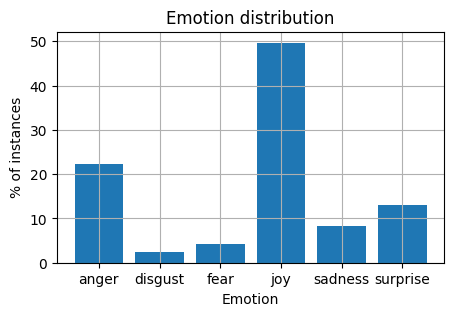

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

### <a id='toc1_5_3_'></a>[**1.4.2 Stopword Removal (DON'T DO IT)**](#toc0_)
A important step in normal NLP pipeline, but we **DON'T** do here, since it include some word that might totally change the tone. (e.g. stopword list includes "not")

In [96]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
if "not" in stop_words:
    index = stop_words.index("not")
    print("Index of 'not':", index)
else:
    print("'not' is not in stop_words")

Index of 'not': 104


### <a id='toc1_5_3_'></a>[**1.4.3 Lowercasing (DON'T DO IT)**](#toc0_)
### <a id='toc1_5_3_'></a>[**1.4.4 Stemming & Lemmatization (DON'T DO IT)**](#toc0_)
### <a id='toc1_5_3_'></a>[**1.4.5 Removing Punctuation, Numbers and Extra Spaces (DON'T DO IT)**](#toc0_)
These tree are also important step in normal NLP pipeline, but we **DON'T** do here, since it may break the slang or change the emotion intensity. For example, this lowercasing, lemmatization, and removing punctuation could change "I'm CRYING!!!" into "I'm cry", such a huge loss in the emotion intensity!!! Also numbers and extra spaces are important in short text, for example number "666666" means good and extra space in "Oh, its         good." might be an alternative of "..." which represent silence (may be negative tone).

# <a id='toc1_2_'></a>[**1.2. Strategy**](#toc1_2_)
## <a id='toc1_6_1_'></a>[Load Data & Construct Psuedo Data from Labeled Data](#toc0_)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

PATH = r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Competition\data\task-emotion-recognition"

# Load data
train_df = pd.read_csv(f"{PATH}/df_arrange_train.csv")
test_df  = pd.read_csv(f"{PATH}/df_arrange_test.csv")   # official test, NO labels

# Create pseudo-train / pseudo-test from *labeled* train_df
train_df_pseudo, test_df_pseudo = train_test_split(
    train_df,
    test_size=0.25,                  # 25% of original train as pseudo-test; tweak if you like
    # stratify=train_df['emotion'],  # keep label distribution similar
    random_state=10000               # for reproducibility
)

## <a id='toc1_6_1_'></a>[Useful Function](#toc0_)

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', fmt = '.2f',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = fmt
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

def evaluate_classifier(y_train, y_train_pred, y_test, y_test_pred, class_names=None, title="Confusion Matrix", fmt = 'd'):
    """
    Evaluate classifier performance on train and test predictions.
    
    Parameters:
        y_train: true training labels
        y_train_pred: predicted training labels
        y_test: true test labels
        y_test_pred: predicted test labels
        class_names: list of class names for confusion matrix
        title: title for confusion matrix plot
    """
    
    # Accuracy
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    print(f"Training accuracy: {acc_train:.2f}")
    print(f"Testing accuracy: {acc_test:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    
    # Confusion matrix
    # cm = confusion_matrix(y_test, y_test_pred)
    # plot_confusion_matrix(cm, classes=class_names, title=title, fmt = fmt)
    cm_tree_normalize = confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize='true') 
    plot_confusion_matrix(cm_tree_normalize, classes=class_names, title=title, fmt = '.2f')

In [5]:
print("="*20,"pseuso train df: proportion of each label in train data","="*20)
print("Emotion proportion:",train_df_pseudo["emotion"].value_counts()/len(train_df_pseudo))
print("="*20,"pseuso test df: proportion of each label in train data","="*20)
print("Emotion proportion:",test_df_pseudo["emotion"].value_counts()/len(test_df_pseudo))

==================== pseuso train df: proportion of each label in train data ====================
Emotion proportion: emotion
joy         0.496172
anger       0.222819
surprise    0.131331
sadness     0.081855
fear        0.042153
disgust     0.025670
Name: count, dtype: float64
==================== pseuso test df: proportion of each label in train data ====================
Emotion proportion: emotion
joy         0.499123
anger       0.224756
surprise    0.130627
sadness     0.082352
fear        0.041343
disgust     0.021799
Name: count, dtype: float64


## <a id='toc1_6_1_'></a>[Using Raw Texts](#toc0_)

In [3]:
X_train_pseudo = train_df_pseudo['text']
y_train_pseudo = train_df_pseudo['emotion']
X_test_pseudo   = test_df_pseudo['text']
y_test_pseudo   = test_df_pseudo['emotion']
# Check dimension
print('X_train_pseudo.shape: ', X_train_pseudo.shape); print('y_train_pseudo.shape: ', y_train_pseudo.shape)
print('X_test_pseudo.shape:   ', X_test_pseudo.shape);   print('y_test_pseudo.shape:   ', y_test_pseudo.shape)

X_train_pseudo.shape:  (35917,)
y_train_pseudo.shape:  (35917,)
X_test_pseudo.shape:    (11973,)
y_test_pseudo.shape:    (11973,)


# <a id='toc1_6_'></a>[**2. Feature engineering**](#toc0_)
## <a id='toc1_6_1_'></a>[Using Bag of Words](#toc0_)

In [4]:
# ======================================================================
# BOW 500
# ======================================================================
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# Build analyzers (bag-of-words)
BOW_500_psuedo = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# Apply analyzer to training data
BOW_500_psuedo.fit(train_df_pseudo['text'])
X_train_pseudo_BOW_500 = BOW_500_psuedo.transform(train_df_pseudo['text'])
y_train_pseudo_BOW_500 = train_df_pseudo['emotion']
X_test_pseudo_BOW_500   = BOW_500_psuedo.transform(test_df_pseudo['text'])
y_test_pseudo_BOW_500   = test_df_pseudo['emotion']
# Check dimension
print('X_train_pseudo.shape: ', X_train_pseudo_BOW_500.shape); print('y_train_pseudo.shape: ', y_train_pseudo_BOW_500.shape)
print('X_test_pseudo.shape:   ', X_test_pseudo_BOW_500.shape);   print('y_test_pseudo.shape:   ', y_test_pseudo_BOW_500.shape)

C:\Users\chenw\anaconda3\envs\dm2025\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_pseudo.shape:  (35917, 500)
y_train_pseudo.shape:  (35917,)
X_test_pseudo.shape:    (11973, 500)
y_test_pseudo.shape:    (11973,)


## <a id='toc1_6_1_'></a>[Using TF-IDF](#toc0_)

In [12]:
# ======================================================================
# TF-IDF 1000
# ======================================================================
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Build analyzers (TF-IDF)
TFIDF_1000_psuedo = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
# (Optional) remove common stopwords (This changes result but I think it is more useful.)
# TFIDF_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize, lowercase=True, stop_words='english')

# Apply analyzer to training data
TFIDF_1000_psuedo.fit(train_df_pseudo['text'])
X_train_pseudo_TFIDF_1000 = TFIDF_1000_psuedo.transform(train_df_pseudo['text'])
y_train_pseudo_TFIDF_1000 = train_df_pseudo['emotion']
X_test_pseudo_TFIDF_1000   = TFIDF_1000_psuedo.transform(test_df_pseudo['text'])
y_test_pseudo_TFIDF_1000   = test_df_pseudo['emotion']
# Check dimension
print('X_train_pseudo.shape: ', X_train_pseudo_TFIDF_1000.shape); print('y_train_pseudo.shape: ', y_train_pseudo_TFIDF_1000.shape)
print('X_test_pseudo.shape:   ', X_test_pseudo_TFIDF_1000.shape);   print('y_test_pseudo.shape:   ', y_test_pseudo_TFIDF_1000.shape)

C:\Users\chenw\anaconda3\envs\dm2025\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_pseudo.shape:  (35917, 1000)
y_train_pseudo.shape:  (35917,)
X_test_pseudo.shape:    (11973, 1000)
y_test_pseudo.shape:    (11973,)


## <a id='toc1_6_1_'></a>[Using Embeddings](#toc0_)

In [18]:
from dotenv import load_dotenv
import os
import time
import pandas as pd
from google import genai
from google.api_core import exceptions
from google.genai import types

# -------------------- 1. Init Gemini client (once) --------------------
# Assumes GOOGLE_API_KEY is already in your environment or .env
load_dotenv(dotenv_path="./config/.env")
api_key = os.getenv("GOOGLE_API_KEY")
if api_key is None:
    raise ValueError("GOOGLE_API_KEY not found in environment variables.")
client = genai.Client(api_key=api_key)

# -------------------- 2. Embedding function ------------------------
# Define our function to get the embeddings with Gemini
def get_gemini_embedding(text: str, model: str="gemini-embedding-001"):
    """
    Return the raw embeddings object from Gemini for a single text.
    Handles rate limiting with a simple retry.
    """
    try:
        result = client.models.embed_content(model=model, contents=[text])
        # 100 requests per minute limit -> 60s / 100 = 0.6s per request
        # buffer time to avoid rate limits
        time.sleep(0.6)
        return result.embeddings                                       # Keep raw for now; we'll convert later
    except exceptions.ResourceExhausted as e:
        print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
        time.sleep(5)                                                  # Wait for 5 seconds before the next attempt
        return get_gemini_embedding(text, model)                       # Retry the request
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [21]:
# -------------------- 3. Stratified sampling function ------------------------
def stratified_sample(df: pd.DataFrame, n_samples: int, stratify_col: str = 'emotion', random_state: int = 42) -> pd.DataFrame:
    """
    Take a stratified sample of size n_samples from df based on stratify_col.
    It means we have the same distribution of labels as in the full dataset.
    """
    if n_samples >= len(df):
        return df.copy() # Return a copy if requested sample is larger or equal
    sampled_df = df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(n=max(0, int(round(len(x) / len(df) * n_samples))))
    )

    # Adjust for rounding errors to get the exact number of samples
    current_samples = len(sampled_df)
    if current_samples < n_samples:
        remaining_indices = df.index.difference(sampled_df.index)
        additional_samples = df.loc[remaining_indices].sample(n=n_samples - current_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, additional_samples])
    elif current_samples > n_samples:
        sampled_df = sampled_df.sample(n=n_samples, random_state=42)
    return sampled_df

In [39]:
# -------------------- 3. Apply to pseudo (small) dataset ------------------------
# How many total rows you want to embed from this dataset
total_extractions = 50
train_ratio = 0.8
test_ratio = 0.2

n_train_to_sample = int(total_extractions * train_ratio)
n_test_to_sample = int(total_extractions * test_ratio)

column_name = "text"      # the text column
label_col = "emotion"     # the label column (4 or 6 emotions, both OK)

print(f"Sampling {n_train_to_sample} rows from the training set...")
train_df_new = stratified_sample(train_df_pseudo, n_train_to_sample, 'emotion')
print(f"Sampling {n_test_to_sample} rows from the test set...")
test_df_new = stratified_sample(test_df_pseudo, n_test_to_sample, 'emotion')

Sampling 40 rows from the training set...
Sampling 10 rows from the test set...


C:\Users\chenw\AppData\Local\Temp\ipykernel_27644\703651090.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(
C:\Users\chenw\AppData\Local\Temp\ipykernel_27644\703651090.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(


In [40]:
print("\nGenerating embeddings for the new training set...")
train_df_new["embeddings"] = train_df_new[column_name].apply(get_gemini_embedding)
print("\nGenerating embeddings for the new test set...")
test_df_new["embeddings"] = test_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new training set...

Generating embeddings for the new test set...


In [43]:
from google.genai import types

# After getting the embeddings we need to convert the Gemini type ContentDict of the embeddings into a simple list with them
train_df_new['embeddings_values'] = train_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])
test_df_new['embeddings_values'] = test_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])

train_df_new.head(3) #We can see the new column with the embeddings 

,id,text,split,emotion,embeddings,embeddings_values
46344,0x35e01c,They’re so angry!,train,anger,"[values=[-0.010310654, -0.008351523, -0.002440...","[-0.010310654, -0.008351523, -0.0024406195, -0..."
12819,0x13792f,"Not really, it can bind *itself* (though not f...",train,anger,"[values=[0.03047738, 0.0057144137, 0.001876076...","[0.03047738, 0.0057144137, 0.0018760767, -0.06..."
35157,0x3bb3e6,"@healeyraine I'm offended, I actually am",train,anger,"[values=[-0.0044557443, 0.019885521, 0.0038159...","[-0.0044557443, 0.019885521, 0.0038159697, -0...."


# <a id='toc1_6_'></a>[**3. Simple Model Implementation Steps (on Pseudo Data)**](#toc0_)
## <a id='toc1_5_3_'></a>[**3.1 Naive Bayes + BOW**](#toc0_)

Using scikit-learn DecisionTreeClassifier performs word frequency and uses these as features to train a model.

## <a id='toc1_5_3_'></a>[**3.2 Decision Tree + BOW**](#toc0_)

## <a id='toc1_5_3_'></a>[**3.3 SVM + TF-IDF**](#toc0_)

In [12]:
# ======================================================================
# Naive Bayes + BOW 500
# ======================================================================
import pandas as pd
from sklearn.naive_bayes import MultinomialNB

# Build the Naive Bayes model
model_NB_pseudo = MultinomialNB() 
model_NB_pseudo.fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500)                         # Train
y_train_pred_NB_pseudo = model_NB_pseudo.predict(X_train_pseudo_BOW_500)            # Predict on train
y_test_pred_NB_pseudo = model_NB_pseudo.predict(X_test_pseudo_BOW_500)              # Predict on test

# ======================================================================
# Weighted Naive Bayes + BOW 500
# ======================================================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Prepare WEIGHT
classes = np.array(['joy','anger','surprise','sadness','fear','disgust'])
weights = compute_class_weight(class_weight='balanced',classes=classes,y=y_train_pseudo_BOW_500)
class_weights = dict(zip(classes, weights))
sample_weights = train_df_pseudo['emotion'].map(class_weights).values

# Build the Naive Bayes model with WEIGHT
model_NB_pseudo_weight = MultinomialNB() 
model_NB_pseudo_weight.partial_fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500, classes=classes, sample_weight=sample_weights)
y_train_pred_NB_pseudo_weight = model_NB_pseudo_weight.predict(X_train_pseudo_BOW_500)            # Predict on train
y_test_pred_NB_pseudo_weight = model_NB_pseudo_weight.predict(X_test_pseudo_BOW_500)              # Predict on test

# ======================================================================
# Calibrated Naive Bayes + BOW 500
# ======================================================================
# Build the Naive Bayes model with CALIBRATION
from sklearn.calibration import CalibratedClassifierCV
# Build the Naive Bayes model
model_NB_pseudo = MultinomialNB() 
model_NB_pseudo_calibrate = CalibratedClassifierCV(model_NB_pseudo, method="isotonic")
model_NB_pseudo_calibrate.fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500)
y_train_pred_NB_pseudo_calibrate = model_NB_pseudo_calibrate.predict(X_train_pseudo_BOW_500)            # Predict on train
y_test_pred_NB_pseudo_calibrate = model_NB_pseudo_calibrate.predict(X_test_pseudo_BOW_500)              # Predict on test

In [14]:
# ======================================================================
#  Decision Tree + BOW 500
# ======================================================================
from sklearn.tree import DecisionTreeClassifier

# Build DecisionTree model
model_DT_pseudo = DecisionTreeClassifier(random_state=1)
model_DT_pseudo = model_DT_pseudo.fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500)              # Train
y_train_pred_DT_pseudo = model_DT_pseudo.predict(X_train_pseudo_BOW_500)            # Predict on train
y_test_pred_DT_pseudo = model_DT_pseudo.predict(X_test_pseudo_BOW_500)              # Predict on test

In [15]:
# ======================================================================
#  SVM + TF-IDF 1000
# ======================================================================
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

# Build SVM model
model_SVM_pseudo = LinearSVC(class_weight="balanced", random_state=42)
model_SVM_pseudo.fit(X_train_pseudo_TFIDF_1000, y_train_pseudo_TFIDF_1000)
y_train_pred_SVM_pseudo_1000 = model_SVM_pseudo.predict(X_train_pseudo_TFIDF_1000)            # Predict on train
y_test_pred_SVM_pseudo_1000 = model_SVM_pseudo.predict(X_test_pseudo_TFIDF_1000)              # Predict on test

Training accuracy: 0.58
Testing accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

       anger       0.48      0.42      0.45      2691
     disgust       0.07      0.03      0.05       261
        fear       0.25      0.26      0.26       495
         joy       0.66      0.79      0.72      5976
     sadness       0.42      0.19      0.27       986
    surprise       0.50      0.47      0.48      1564

    accuracy                           0.57     11973
   macro avg       0.40      0.36      0.37     11973
weighted avg       0.55      0.57      0.56     11973



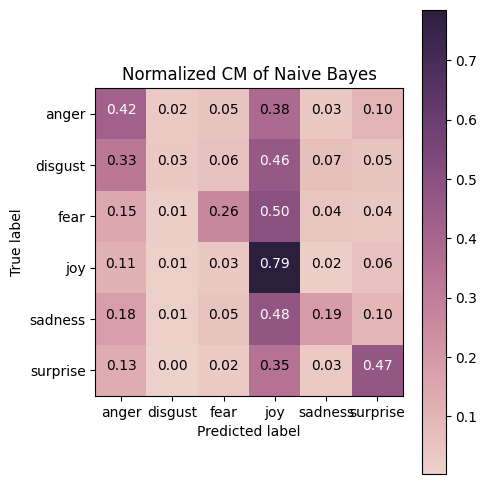

Training accuracy: 0.45
Testing accuracy: 0.43

Classification Report:
               precision    recall  f1-score   support

       anger       0.46      0.28      0.35      2691
     disgust       0.06      0.33      0.10       261
        fear       0.14      0.50      0.22       495
         joy       0.83      0.48      0.61      5976
     sadness       0.23      0.34      0.28       986
    surprise       0.38      0.56      0.46      1564

    accuracy                           0.43     11973
   macro avg       0.35      0.42      0.34     11973
weighted avg       0.59      0.43      0.48     11973



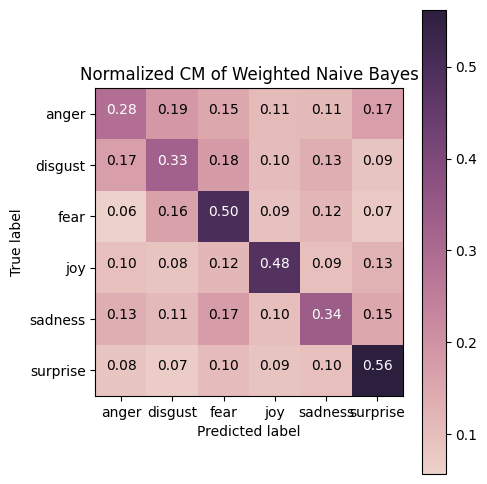

Training accuracy: 0.59
Testing accuracy: 0.58

Classification Report:
               precision    recall  f1-score   support

       anger       0.49      0.42      0.45      2691
     disgust       0.00      0.00      0.00       261
        fear       0.38      0.15      0.22       495
         joy       0.63      0.83      0.72      5976
     sadness       0.48      0.16      0.24       986
    surprise       0.53      0.41      0.46      1564

    accuracy                           0.58     11973
   macro avg       0.42      0.33      0.35     11973
weighted avg       0.55      0.58      0.55     11973



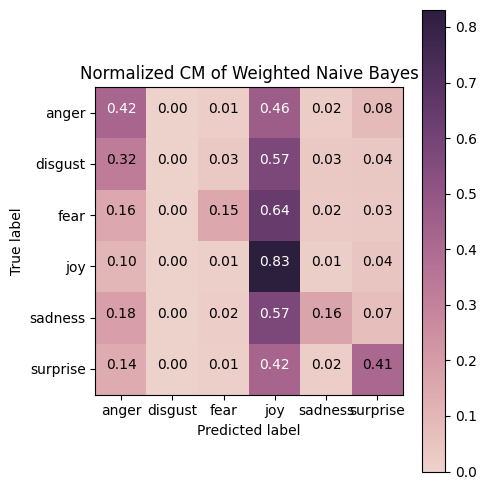

Training accuracy: 0.99
Testing accuracy: 0.48

Classification Report:
               precision    recall  f1-score   support

       anger       0.37      0.39      0.38      2691
     disgust       0.04      0.05      0.04       261
        fear       0.18      0.16      0.17       495
         joy       0.65      0.65      0.65      5976
     sadness       0.23      0.20      0.21       986
    surprise       0.36      0.36      0.36      1564

    accuracy                           0.48     11973
   macro avg       0.31      0.30      0.30     11973
weighted avg       0.48      0.48      0.48     11973



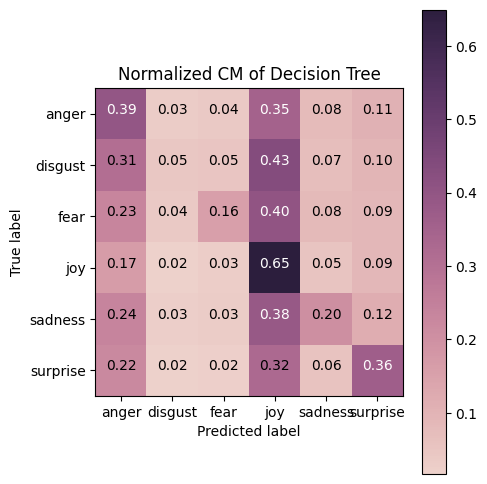

Training accuracy: 0.61
Testing accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

       anger       0.53      0.42      0.47      2691
     disgust       0.10      0.30      0.15       261
        fear       0.26      0.53      0.35       495
         joy       0.78      0.69      0.73      5976
     sadness       0.35      0.38      0.36       986
    surprise       0.49      0.54      0.51      1564

    accuracy                           0.57     11973
   macro avg       0.42      0.48      0.43     11973
weighted avg       0.61      0.57      0.58     11973



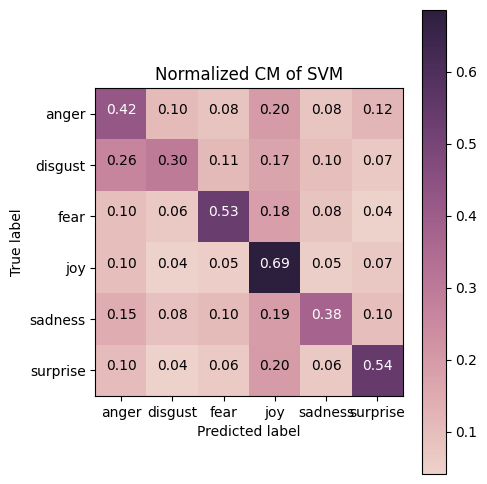

In [19]:
class_names = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
evaluate_classifier(y_train_pseudo, y_train_pred_NB_pseudo, y_test_pseudo, y_test_pred_NB_pseudo, class_names=class_names, title="Normalized CM of Naive Bayes")
evaluate_classifier(y_train_pseudo, y_train_pred_NB_pseudo_weight, y_test_pseudo, y_test_pred_NB_pseudo_weight, class_names=class_names, title="Normalized CM of Weighted Naive Bayes")
evaluate_classifier(y_train_pseudo, y_train_pred_NB_pseudo_calibrate, y_test_pseudo, y_test_pred_NB_pseudo_calibrate, class_names=class_names, title="Normalized CM of Weighted Naive Bayes")
evaluate_classifier(y_train_pseudo, y_train_pred_DT_pseudo, y_test_pseudo, y_test_pred_DT_pseudo, class_names=class_names, title="Normalized CM of Decision Tree")
evaluate_classifier(y_train_pseudo, y_train_pred_SVM_pseudo_1000, y_test_pseudo, y_test_pred_SVM_pseudo_1000, class_names=class_names, title="Normalized CM of SVM")

# <a id='toc1_6_'></a>[**4. Complex Model Implementation Steps (on Pseudo Data)**](#toc0_)
## <a id='toc1_5_3_'></a>[**4.1 DistilRoBERTa-base**](#toc0_)

In [4]:
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 1. Build raw dataset from pandas
train_ds_pseudo = Dataset.from_dict({
    "text": train_df_pseudo["text"].tolist(),
    "labels": train_df_pseudo["emotion"].tolist()   # strings for now
})

test_ds_pseudo = Dataset.from_dict({
    "text": test_df_pseudo["text"].tolist(),
    "labels": test_df_pseudo["emotion"].tolist()
})

# 2. Map string labels → ints
label_list = sorted(train_df_pseudo["emotion"].unique())
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

def encode_labels(example):
    example["labels"] = label2id[example["labels"]]
    return example

train_ds_pseudo = train_ds_pseudo.map(encode_labels)
test_ds_pseudo  = test_ds_pseudo.map(encode_labels)

# 3. Tokenize text via .map
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=128
    )
train_ds_pseudo = train_ds_pseudo.map(tokenize_batch, batched=True)
test_ds_pseudo  = test_ds_pseudo.map(tokenize_batch, batched=True)

# 4. Drop raw text column (model doesn’t need it)
train_ds_pseudo = train_ds_pseudo.remove_columns(["text"])
test_ds_pseudo  = test_ds_pseudo.remove_columns(["text"])

# 5. Set format to PyTorch tensors
train_ds_pseudo.set_format(type="torch")
test_ds_pseudo.set_format(type="torch")

# 6. Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 7. Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 8. Trainer & Training config
training_args = TrainingArguments(
    output_dir="./roberta",
    per_device_train_batch_size=16,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    fp16=False,  # True only if you have a GPU that supports it
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_pseudo,
    eval_dataset=test_ds_pseudo,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

ERROR! Session/line number was not unique in database. History logging moved to new session 103


Map:   0%|          | 0/35917 [00:00<?, ? examples/s]

Map:   0%|          | 0/11973 [00:00<?, ? examples/s]

Map:   0%|          | 0/35917 [00:00<?, ? examples/s]

Map:   0%|          | 0/11973 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\chenw\AppData\Local\Temp\ipykernel_21732\870078209.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.446500
100,1.181000
150,1.123600
200,1.088800
250,1.080000
300,1.018600
350,0.999600
400,0.998700
450,1.024100
500,0.999900


TrainOutput(global_step=2245, training_loss=0.9679729096342566, metrics={'train_runtime': 371.7245, 'train_samples_per_second': 96.623, 'train_steps_per_second': 6.039, 'total_flos': 380067797476224.0, 'train_loss': 0.9679729096342566, 'epoch': 1.0})

In [5]:
import torch
import pandas as pd

def predict_with_probs(trainer, train_or_test_ds, train_or_test_df, id2label):
    """
    Run prediction with a HuggingFace Trainer model and return a dataframe
    containing predicted labels + per-class probabilities.

    Args:
        trainer : HuggingFace Trainer object
        test_ds : tokenized test Dataset
        test_df : original pandas dataframe (must align with test_ds order)
        id2label : dict mapping {class_id: label_string}

    Returns:
        DataFrame with columns:
            - pred_label
            - prob_<label_name> (one per class)
    """

    # 1. Predict
    train_or_test_pred = trainer.predict(train_or_test_ds)

    # 2. Extract logits → probability
    logits = train_or_test_pred.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    # 3. Argmax → predicted class id → label string
    pred_ids = probs.argmax(axis=1)
    pred_labels = [id2label[int(i)] for i in pred_ids]

    # 4. Build output dataframe
    out_df = train_or_test_df.copy()
    out_df["pred_label"] = pred_labels

    # 5. Add probability columns
    for class_id, class_name in id2label.items():
        out_df[f"prob_{class_name}"] = probs[:, class_id]

    return out_df

In [6]:
df_output_train_pseudo_DistilRoBERTa_base = predict_with_probs(trainer=trainer,
                                                               train_or_test_ds=train_ds_pseudo,
                                                               train_or_test_df=train_df_pseudo,
                                                               id2label=id2label)
df_output_train_pseudo_DistilRoBERTa_base.head(3)

,id,text,split,emotion,pred_label,prob_anger,prob_disgust,prob_fear,prob_joy,prob_sadness,prob_surprise
30795,0xa56ae4,"Well, that's just a distraction for the color ...",train,joy,joy,0.269613,0.019793,0.009424,0.410959,0.152730,0.137481
33523,0x0a62dd,That’s blasphemous 😩,train,anger,anger,0.580445,0.197182,0.023289,0.097273,0.074159,0.027652
2824,0xd0c564,I am sorry but what is a wholesome meme,train,surprise,joy,0.049171,0.008237,0.005461,0.427767,0.427062,0.082302


In [7]:
df_output_test_pseudo_DistilRoBERTa_base = predict_with_probs(trainer=trainer,
                                                               train_or_test_ds=test_ds_pseudo,
                                                               train_or_test_df=test_df_pseudo,
                                                               id2label=id2label)
df_output_test_pseudo_DistilRoBERTa_base.head(3)

,id,text,split,emotion,pred_label,prob_anger,prob_disgust,prob_fear,prob_joy,prob_sadness,prob_surprise
44140,0x19b50b,Finishing peeing and then still feeling like y...,train,joy,sadness,0.140555,0.032008,0.230217,0.262612,0.267621,0.066987
46622,0x69e48c,Kill me.,train,joy,anger,0.734919,0.052422,0.061137,0.083487,0.045846,0.022188
19832,0x0c0183,I feel bad for these guys. I'd like to be able...,train,disgust,sadness,0.108312,0.052814,0.048350,0.198753,0.565445,0.026325


In [17]:
''' 
# Save results
out_path = "df_output_train_pseudo_DistilRoBERTa_base.csv"
df_output_train_pseudo_DistilRoBERTa_base.to_csv(out_path, index=False)
print("Saved predictions to:", out_path)

out_path = "df_output_test_pseudo_DistilRoBERTa_base.csv"
df_output_test_pseudo_DistilRoBERTa_base.to_csv(out_path, index=False)
print("Saved predictions to:", out_path)
'''

' \n# Save results\nout_path = "df_output_train_pseudo_DistilRoBERTa_base.csv"\ndf_output_train_pseudo_DistilRoBERTa_base.to_csv(out_path, index=False)\nprint("Saved predictions to:", out_path)\n\nout_path = "df_output_test_pseudo_DistilRoBERTa_base.csv"\ndf_output_test_pseudo_DistilRoBERTa_base.to_csv(out_path, index=False)\nprint("Saved predictions to:", out_path)\n'

In [21]:
# Notice that I move the file to "result" folder

PATH_result = PATH_result = r'C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Exercise\results\task-emotion-recognition'

df_output_train_pseudo_DistilRoBERTa_base = pd.read_csv(f"{PATH_result}/df_output_test_pseudo_DistilRoBERTa_base.csv")
df_output_test_pseudo_DistilRoBERTa_base = pd.read_csv(f"{PATH_result}/df_output_test_pseudo_DistilRoBERTa_base.csv")
y_train_pred_distilroberta_base = df_output_train_pseudo_DistilRoBERTa_base["pred_label"].to_numpy()
y_test_pred_distilroberta_base = df_output_test_pseudo_DistilRoBERTa_base["pred_label"].to_numpy()

Training accuracy: 1.00
Testing accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

       anger       0.59      0.63      0.61      2691
     disgust       0.14      0.02      0.03       261
        fear       0.50      0.54      0.52       495
         joy       0.77      0.84      0.81      5976
     sadness       0.51      0.38      0.43       986
    surprise       0.63      0.53      0.57      1564

    accuracy                           0.68     11973
   macro avg       0.52      0.49      0.50     11973
weighted avg       0.67      0.68      0.67     11973



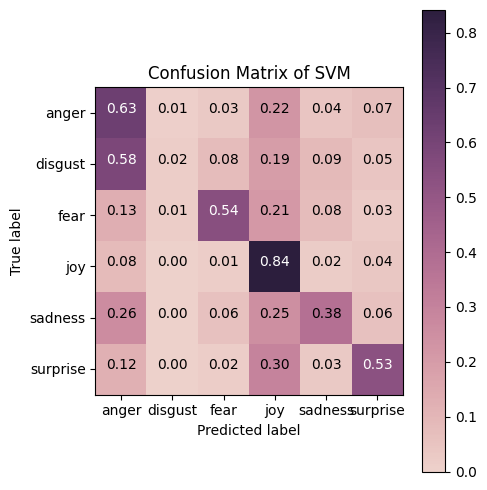

In [22]:
class_names = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
evaluate_classifier(y_train_pred_distilroberta_base, y_test_pred_distilroberta_base, y_test_pseudo, y_test_pred_distilroberta_base, class_names=class_names, title="Confusion Matrix of SVM")

The above is not the result of SVM but i dont want to rerun

## <a id='toc1_5_3_'></a>[**4.2 DistilRoBERTa-base (Improved Model)**](#toc0_)

Improved Model: Baseline Model + class-weights + label smoothing + R-Drop + better preprocessing + metrics + stable seeds

I organize the differences into:
- What changed?
- Why it improves?

A. Data / Preprocessing Differences
1. Added: set_seed()
✔ Baseline: No seed
✔ Improved: repeatable results
Why: Makes training deterministic → stable reproducibility

3. Tokenization change: max_length 128 → 160
✔ Baseline: fixed 128
✔ Improved: 160 (slightly safer)
Where: tokenize_batch
Why: Prevents truncation for slightly longer texts → keeps more semantics


4. Padding strategy (???)
✔ Baseline: No explicit reason for dynamic padding
✔ Improved: Dynamic padding (DataCollator only)
Why:
- Faster training
- Shorter sequences → lower memory
- Recommended by HF

B. Class Imbalance Handling
1. NEW: class_weights
✔ Baseline: No balancing
✔ Improved: Weighted CE → improves macro-F1 significantly
Why:
- Large datasets are NOT balanced.
- CrossEntropyLoss strongly biases toward frequent classes.
- Weighted CE fixes this by giving more penalty to rare classes.

C. Loss Function and Trainer Architecture
1. NEW: label_smoothing
✔ Baseline: CE loss only
✔ Improved: CE + smoothing
Where: inside custom Trainer init
Why:
- Prevents model from overconfident predictions
- Reduces overfitting
- Works extremely well with Transformers

2. NEW: R-Drop (two forward passes + KL loss)
Where: compute_loss()
- outputs1 = model(**inputs)
- outputs2 = model(**inputs)  # dropout randomness
- KL(logits1 || logits2) # Add symmetric KL regularization
Why:
- Makes the model consistent under dropout
- Gives regularization stronger than Dropout alone
- Improves robustness to noise + pseudo-labels
- Improves calibration + generalization
- Huge benefit for pseudo-label training

3. NEW: Swallowing extra keyword arguments
Where: def compute_loss(..., **kwargs):
Why: Stability for future HF updates. This prevents Trainer from crashing when HF passes extra internal args.

4. NEW: Ensuring class_weights on same device
Where: self.loss_fct.weight = self.class_weights.to(model.device)
Why: Prevents CPU/GPU mismatch runtime errors.

D. Evaluation Metrics
1. NEW: Added macro-F1 computation
Where: def compute_metrics(eval_pred):
Why:
= Accuracy bad for imbalanced datasets
- macro-F1 measures fairness across labels
- Tracks real performance


E. TrainingArguments Differences
10. Training length
Baseline: num_train_epochs=1
Improved: num_train_epochs=3

Why: More epochs → better fitting (since pseudo-labels).
But R-Drop + smoothing prevent overfitting.

11. Learning rate
Baseline: 2e-5
Improved: 3e-5

Why: Slightly more aggressive LR but stabilized by R-Drop + smoothing.
12. Evaluation batch size increased
Baseline: 16
Improved: 32
Why: Faster evaluation and more stable stats.

13. Mixed precision
fp16=torch.cuda.is_available()

Why:
GPU optimization → faster + lower memory.

14. Early stopping

(You imported it but did not use, but still improvement potential.)

F. Trainer Switch
15. Replaced Trainer → RDropWeightedTrainer

Where: building trainer
Why:
You override compute_loss(), so need a custom Trainer class.


vs 原始 Trainer 的「三大升級」
原始 Trainer：
單次 forward
plain CrossEntropy（無權重、無 smoothing）
output.loss 直接 backward

你現在的 RDropWeightedTrainer：
Loss function 升級
class weights（處理不平衡）
label smoothing（抗 overfitting / 過度自信）
Forward 升級
同一 batch forward 兩次（利用 dropout randomness）
兩次 CrossEntropy 取平均（減少 noise）
Regularization 升級（R-Drop）
加入 α × KL(p1 || p2) (雙向)
強迫兩次預測分布一致 → 提升穩定性與泛化
如果你想要一個 簡化版對照：

7. 總結：一眼看懂 vs 原始 Trainer 的「三大升級」

原始 Trainer：

單次 forward

plain CrossEntropy（無權重、無 smoothing）

output.loss 直接 backward

你現在的 RDropWeightedTrainer：

Loss function 升級

class weights（處理不平衡）

label smoothing（抗 overfitting / 過度自信）

Forward 升級

同一 batch forward 兩次（利用 dropout randomness）

兩次 CrossEntropy 取平均（減少 noise）

Regularization 升級（R-Drop）

加入 α × KL(p1 || p2) (雙向)

強迫兩次預測分布一致 → 提升穩定性與泛化

如果你想要一個 簡化版對照：

In [45]:
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from collections import Counter
from sklearn.metrics import f1_score
import numpy as np
import torch
import torch.nn as nn
import random

# 0. Fix seed (New)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

model_name = "distilroberta-base"                     # (Same)
tokenizer = AutoTokenizer.from_pretrained(model_name) # (Same)

# 1. Build raw dataset from pandas (Same)
train_ds_pseudo = Dataset.from_dict({
    "text": train_df_pseudo["text"].tolist(),
    "labels": train_df_pseudo["emotion"].tolist()   # strings for now
})

test_ds_pseudo = Dataset.from_dict({
    "text": test_df_pseudo["text"].tolist(),
    "labels": test_df_pseudo["emotion"].tolist()
})

# 2. Map string labels → ints (Same)
label_list = sorted(train_df_pseudo["emotion"].unique())
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

def encode_labels(example):
    example["labels"] = label2id[example["labels"]]
    return example

train_ds_pseudo = train_ds_pseudo.map(encode_labels)
test_ds_pseudo  = test_ds_pseudo.map(encode_labels)
num_labels = len(label_list) 

# ================================================================================================
# NEW. Calculate class weights to deal with imbalance: weight_k = total / (num_labels * count_k)
# ================================================================================================
# Count by string label
label_counts = Counter(train_df_pseudo["emotion"])
total = sum(label_counts.values())

class_weights = torch.zeros(num_labels, dtype=torch.float)

for label, idx in label2id.items():
    count = label_counts[label]
    class_weights[idx] = total / (num_labels * count)

print("Label counts:", label_counts)
print("Class weights:", class_weights)

# ================================================================================================
# 3. Tokenizer via .map + 動態 padding
#    - max_length = 160: 比 128 長一點，但不硬性 pad，交給 DataCollator 動態 padding。
# ================================================================================================
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=160,     # Longer then my original 128 to avoid unecessary cut
        # 不指定 padding="max_length" -> 先不 pad，讓 collator 動態處理
    )
train_ds_pseudo = train_ds_pseudo.map(tokenize_batch, batched=True)
test_ds_pseudo  = test_ds_pseudo.map(tokenize_batch, batched=True)

# 4. Drop raw text column (model doesn’t need it) (same form)
train_ds_pseudo = train_ds_pseudo.remove_columns(["text"])
test_ds_pseudo  = test_ds_pseudo.remove_columns(["text"])

# 5. Set format to PyTorch tensors (same form)
train_ds_pseudo.set_format(type="torch")
test_ds_pseudo.set_format(type="torch")

# 6. Model (same form)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# 7. Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/35917 [00:00<?, ? examples/s]

Map:   0%|          | 0/11973 [00:00<?, ? examples/s]

Label counts: Counter({'joy': 17821, 'anger': 8003, 'surprise': 4717, 'sadness': 2940, 'fear': 1514, 'disgust': 922})
Class weights: tensor([0.7480, 6.4926, 3.9539, 0.3359, 2.0361, 1.2691])


Map:   0%|          | 0/35917 [00:00<?, ? examples/s]

Map:   0%|          | 0/11973 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
# ================================================================================================
# NEW. Self-defined Trainer：
#    - Self-define loss function: Use class_weights + label_smoothing
#    - Basic R-Drop: forward x 2 + KL loss（可用 alpha 控制）
# ================================================================================================
import torch.nn.functional as F

class RDropWeightedTrainer(Trainer):
    def __init__(self, class_weights=None, label_smoothing=0.0, rdrop_alpha=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing
        self.rdrop_alpha = rdrop_alpha

        if self.class_weights is not None:
            self.loss_fct = nn.CrossEntropyLoss(
                weight=self.class_weights,
                label_smoothing=self.label_smoothing
            )
        else:
            self.loss_fct = nn.CrossEntropyLoss(
                label_smoothing=self.label_smoothing
            )
    def compute_loss(self,model,inputs,return_outputs: bool = False,
        **kwargs,  # <-- swallow num_items_in_batch and any future kwargs
    ):
        labels = inputs.pop("labels")

        # make sure loss weights are on the same device as logits
        if self.class_weights is not None:
            self.loss_fct.weight = self.class_weights.to(model.device)

        # 1st forward
        outputs1 = model(**inputs)
        logits1 = outputs1.logits

        # 2nd forward（Use dropout randomness）
        outputs2 = model(**inputs)
        logits2 = outputs2.logits

        # CrossEntropy loss： Average the two forward passes
        ce_loss1 = self.loss_fct(
            logits1.view(-1, self.model.config.num_labels),
            labels.view(-1),
        )
        ce_loss2 = self.loss_fct(
            logits2.view(-1, self.model.config.num_labels),
            labels.view(-1),
        )
        ce_loss = 0.5 * (ce_loss1 + ce_loss2)

        # R-Drop KL loss（symmetrized KL）
        log_probs1 = F.log_softmax(logits1, dim=-1)
        log_probs2 = F.log_softmax(logits2, dim=-1)
        probs1 = log_probs1.exp()
        probs2 = log_probs2.exp()

        kl_loss = 0.5 * (
            F.kl_div(log_probs1, probs2, reduction="batchmean")
            + F.kl_div(log_probs2, probs1, reduction="batchmean")
        )

        loss = ce_loss + self.rdrop_alpha * kl_loss

        return (loss, outputs1) if return_outputs else loss

# ================================================================================================
# NEW. macro-F1
# ================================================================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"macro_f1": macro_f1}

In [58]:
# 8. Training config & Trainer
training_args = TrainingArguments(
    output_dir="./roberta_baseline",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    seed=42,
)
trainer = RDropWeightedTrainer(
    model=model,
    args=training_args,           # SAME training_args as above
    train_dataset=train_ds_pseudo,
    eval_dataset=test_ds_pseudo,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,  # your precomputed tensor
    label_smoothing=0.05,
    rdrop_alpha=0.5,
)
trainer.train()
trainer.evaluate()

C:\Users\chenw\AppData\Local\Temp\ipykernel_17212\2958876473.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `RDropWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
50,1.973300
100,1.862300
150,1.716500
200,1.629000
250,1.639600
300,1.626300
350,1.564900
400,1.650100
450,1.572200
500,1.560300


{'eval_loss': 1.461597204208374,
 'eval_macro_f1': 0.5201217235135416,
 'eval_runtime': 27.1788,
 'eval_samples_per_second': 440.526,
 'eval_steps_per_second': 13.797,
 'epoch': 3.0}

In [61]:
# 9. Predict
train_pred = trainer.predict(train_ds_pseudo)
test_pred = trainer.predict(test_ds_pseudo)
print(train_pred.predictions.shape)
print(test_pred.predictions.shape)

logits = train_pred.predictions                 # shape: (N, num_labels)
train_pred_ids = logits.argmax(axis=1)     # pick label with highest logit
y_train_pred_distilroberta_improve = [id2label[i] for i in train_pred_ids]

logits = test_pred.predictions                 # shape: (N, num_labels)
test_pred_ids = logits.argmax(axis=1)     # pick label with highest logit
y_test_pred_distilroberta_improve = [id2label[i] for i in test_pred_ids]

(35917, 6)
(11973, 6)


Training accuracy: 0.75
Testing accuracy: 0.64

Classification Report:
               precision    recall  f1-score   support

       anger       0.62      0.55      0.58      2691
     disgust       0.17      0.40      0.24       261
        fear       0.40      0.66      0.50       495
         joy       0.87      0.70      0.78      5976
     sadness       0.40      0.50      0.44       986
    surprise       0.51      0.67      0.58      1564

    accuracy                           0.64     11973
   macro avg       0.49      0.58      0.52     11973
weighted avg       0.69      0.64      0.66     11973



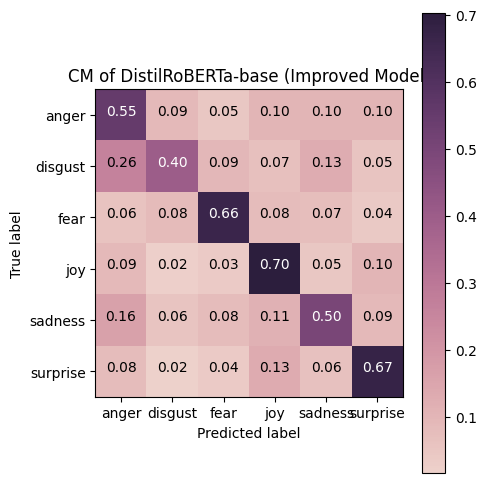

In [64]:
class_names = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
evaluate_classifier(y_train_pseudo, y_train_pred_distilroberta_improve, y_test_pseudo, y_test_pred_distilroberta_improve, class_names=class_names, title="CM of DistilRoBERTa-base (Improved Model)")

In [49]:
# ================================================================================================
# 8.1 Training config
# ================================================================================================
training_args = TrainingArguments(
    output_dir="./roberta_rdrop_v1",   # 模型 & log 儲存位置
    per_device_train_batch_size=16,    # 單 GPU / device 的 batch size
    per_device_eval_batch_size=32,     # eval 可以用大一點 batch（不用反向傳遞）
    num_train_epochs=8,                # 最大 epoch 數，配合 early stopping，實際不一定會跑到 8
    learning_rate=3e-5,                # 比原本的 2e-5 稍高，搭配 scheduler + regularization

    weight_decay=0.01,                 # L2 regularization，防止 overfitting
    adam_beta1=0.9,                    # AdamW beta1，標準設定
    adam_beta2=0.999,                  # AdamW beta2，標準設定

    warmup_ratio=0.06,                 # 前 6% step 使用 linear warmup，有利穩定啟動
    lr_scheduler_type="linear",        # warmup 之後線性下降到 0，適合 fine-tuning transformer

    max_grad_norm=1.0,                 # gradient clipping，避免梯度爆炸（對小資料也有穩定效果）

    logging_strategy="steps",          # 每隔 logging_steps 記錄一次 loss/metric
    logging_steps=50,                  # 每 50 step log 一次，太小會很吵、太大看不到細節

    evaluation_strategy="epoch",       # 每個 epoch 做一次 evaluation
    save_strategy="epoch",             # 每個 epoch 存一次 checkpoint（配合 early stopping）
    load_best_model_at_end=True,       # 訓練結束後自動載入在 eval 上 macro_f1 最好的那個 checkpoint

    metric_for_best_model="macro_f1",  # 以 macro-F1 當作「最好模型」的指標
    greater_is_better=True,            # macro-F1 越大越好

    save_total_limit=2,                # 最多保留 2 個 checkpoint，避免硬碟爆掉

    fp16=True,                        # 如果 GPU 支援，試著改 True 會加速 & 省記憶體
    seed=42,                           # 再次固定 seed（Trainer 自己也會用）

    group_by_length=True,              # (★重要！)依照序列長度分組，配合動態 padding，讓每個 batch 裡句子長度接近 -> 加速、訓練更穩

    report_to="none",                  # 不上傳到 wandb / tensorboard，單純在 console 看 log
)

# ================================================================================================
# 8.2. Trainer + Early Stopping
# ================================================================================================



trainer = RDropWeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_pseudo,
    eval_dataset=test_ds_pseudo,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,   # class weights（處理類別不平衡）
    label_smoothing=0.05,          # label smoothing 0.05
    rdrop_alpha=0.5,               # R-Drop 的權重 α，可以視資料大小調整 0.3~1.0 間
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    # ↑ patience=2 代表：連續兩個 epoch val macro-F1 沒進步，就停止訓練
)
trainer.train()

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

# Implement

In [6]:
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# Build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# Apply analyzer to training data
BOW_500.fit(train_df['text'])
X_train_BOW_500 = BOW_500.transform(train_df['text'])
y_train_BOW_500 = train_df['emotion']
X_test_BOW_500   = BOW_500.transform(test_df['text'])
y_test_BOW_500   = test_df['emotion']
# Check dimension
print('X_train_pseudo.shape: ', X_train_BOW_500.shape); print('y_train_pseudo.shape: ', y_train_BOW_500.shape)
print('X_test_pseudo.shape:   ', X_test_BOW_500.shape);   print('y_test_pseudo.shape:   ', y_test_BOW_500.shape)

C:\Users\chenw\anaconda3\envs\dm2025\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_pseudo.shape:  (47890, 500)
y_train_pseudo.shape:  (47890,)
X_test_pseudo.shape:    (16281, 500)
y_test_pseudo.shape:    (16281,)


In [91]:
# Build the Naive Bayes model with CALIBRATION
from sklearn.calibration import CalibratedClassifierCV

# Build the Naive Bayes model
model_NB = MultinomialNB() 
model_NB_calibrate = CalibratedClassifierCV(model_NB, method="isotonic")
model_NB_calibrate.fit(X_train_BOW_500, y_train_BOW_500)
y_train_pred_NB_calibrate = model_NB_calibrate.predict(X_train_BOW_500)            # Predict on train
y_test_pred_NB_calibrate = model_NB_calibrate.predict(X_test_BOW_500)              # Predict on test
submission = pd.DataFrame({
    "id": test_df["id"],
    "emotion": y_test_pred_NB_calibrate
})
submission.to_csv("df_submission_nb_calibrate.csv", index=False)

In [8]:
from sklearn.naive_bayes import MultinomialNB

# Build the Naive Bayes model
model_NB = MultinomialNB() 
model_NB.fit(X_train_BOW_500, y_train_BOW_500)                         # Train
y_train_pred_NB = model_NB.predict(X_train_BOW_500)            # Predict on train
y_test_pred_NB = model_NB.predict(X_test_BOW_500)              # Predict on test
prob_train_pred_NB = model_NB.predict_proba(X_test_pseudo_BOW_500)
prob_test_pred_NB = model_NB.predict_proba(X_train_pseudo_BOW_500)

In [13]:
PATH_result = r'C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Exercise\results\task-emotion-recognition'

df_train_distilroberta_base = pd.read_csv(f"{PATH_result}/df_train_distilroberta_base.csv")
df_test_distilroberta_base = pd.read_csv(f"{PATH_result}/df_test_distilroberta_base.csv")
y_train_pred_distilroberta_base = df_train_distilroberta_base["pred_label"].to_numpy()
y_test_pred_distilroberta_base = df_test_distilroberta_base["pred_label"].to_numpy()
y_test_pred_distilroberta_base

array(['joy', 'fear', 'joy', ..., 'anger', 'fear', 'joy'], dtype=object)

In [14]:
# For testing set
roberta_test_probs = df_test_distilroberta_base.filter(like="prob_").to_numpy()
roberta_test_pred = df_test_distilroberta_base["pred_label"].to_numpy()

# For train set
roberta_train_probs = df_train_distilroberta_base.filter(like="prob_").to_numpy()
roberta_train_pred = df_train_distilroberta_base["pred_label"].to_numpy()
def combine_models(roberta_probs, roberta_pred, nb_probs, nb_pred, threshold=0.55):
    """
    If RoBERTa is confident (max prob >= threshold) → trust RoBERTa
    If not → fallback to Naive Bayes
    """
    final_preds = []
    final_sources = []   # track who made the decision
    
    for i in range(len(roberta_pred)):
        roberta_conf = roberta_probs[i].max()
        
        if roberta_conf >= threshold:
            final_preds.append(roberta_pred[i])
            final_sources.append("RoBERTa")
        else:
            final_preds.append(nb_pred[i])
            final_sources.append("NaiveBayes")
    
    return np.array(final_preds), np.array(final_sources)


In [15]:
def combine_models(roberta_probs, roberta_pred, nb_probs, nb_pred, threshold=0.55):
    """
    If RoBERTa is confident (max prob >= threshold) → trust RoBERTa
    If not → fallback to Naive Bayes
    """
    final_preds = []
    final_sources = []   # track who made the decision
    
    for i in range(len(roberta_pred)):
        roberta_conf = roberta_probs[i].max()
        
        if roberta_conf >= threshold:
            final_preds.append(roberta_pred[i])
            final_sources.append("RoBERTa")
        else:
            final_preds.append(nb_pred[i])
            final_sources.append("NaiveBayes")
    
    return np.array(final_preds), np.array(final_sources)


In [20]:
final_test_pred, final_test_source = combine_models(
    roberta_probs = roberta_test_probs,
    roberta_pred  = y_test_pred_distilroberta_base,
    nb_probs      = prob_test_pred_NB,
    nb_pred       = y_test_pred_NB,
    threshold     = 0.25
)
final_test_pred

array(['joy', 'fear', 'joy', ..., 'anger', 'fear', 'joy'], dtype='<U8')

In [21]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "emotion": final_test_pred
})
submission.shape
submission.to_csv("df_submission_ensamble.csv", index=False)

In [ ]:
exclude_cols = ["id", "pred_label"]
class_NB = [c for c in df_output_train_pseudo_NB.columns if c not in exclude_cols]
class_roberta_base = [c for c in df_output_train_pseudo_DistilRoBERTa_base.columns if c not in exclude_cols]
# 檢查一下兩邊的 class 是否相同（順序可以不同）
print("Detected Naive Bayes class columns:", class_NB)
print("Detected DistilRoBERTa class columns:", class_roberta_base)

In [ ]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "emotion": y_test_pred_NB
})
submission.to_csv("df_submission_nb.csv", index=False)

In [100]:
X_train = train_df["text"]     # raw text
X_test = test_df["text"]
y_train = train_df["emotion"]

0        I bet there is an army of married couples who ...
1                               This could only end badly.
2        My sister squeezed a lime in her milk when she...
3                                      Thank you so much❤️
4        Stinks because ive been in this program for a ...
                               ...                        
47885                    why is everybody seem sp serious?
47886    You can cross fuck off, its 10f all winter in ...
47887    Guilty Gear actually did that before with Guil...
47888                         One of my favorite episodes.
47889    Texans and Astros both shut out tonight. Houst...
Name: text, Length: 47890, dtype: object

In [103]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# -----------------------------
# 1. Prepare TRAIN dataset
# -----------------------------
train_ds = Dataset.from_dict({
    "text": X_train,          # raw text
    "labels": y_train         # numeric labels
})

# -----------------------------
# 2. Prepare TEST dataset (NO LABELS)
# -----------------------------
test_ds = Dataset.from_dict({
    "text": X_test            # raw text only, no labels
})

In [104]:
# -----------------------------
# 3. Tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

train_ds = train_ds.map(tok, batched=True)
test_ds = test_ds.map(tok, batched=True)

# Remove non-model columns
train_ds = train_ds.remove_columns(["text"])
test_ds = test_ds.remove_columns(["text"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\chenw\anaconda3\envs\dm2025\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chenw\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/47890 [00:00<?, ? examples/s]

Map:   0%|          | 0/16281 [00:00<?, ? examples/s]

In [107]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

^C


In [ ]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

In [106]:
# -----------------------------
# 4. Load Model
# -----------------------------
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(y_train))
)


#model = AutoModelForSequenceClassification.from_pretrained(
#    "distilbert-base-uncased",
#    num_labels=len(set(y_train))
#)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


TypeError: 'builtins.safe_open' object is not iterable

In [ ]:
# -----------------------------
# 5. Training config
# -----------------------------
training_args = TrainingArguments(
    output_dir="./bert",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,        # fast
    weight_decay=0.01,
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
)

# -----------------------------
# 6. Train
# -----------------------------
trainer.train()

# -----------------------------
# 7. Predict on TEST (no labels needed)
# -----------------------------
pred_logits = trainer.predict(test_ds).predictions
test_pred = pred_logits.argmax(axis=1)


### **Student Information**
Name: 黃晨溦

Student ID: 112024803

GitHub ID:

Kaggle name:

Kaggle private scoreboard snapshot: 

![pic_ranking.png](./pics/pic_ranking.png)

---

# **Instructions**

For this lab we have divided the assignments into **three phases/parts**. The `first two phases` refer to the `exercises inside the Master notebooks` of the [DM2025-Lab2-Exercise Repo](https://github.com/difersalest/DM2025-Lab2-Exercise.git). The `third phase` refers to an `internal Kaggle competition` that we are gonna run among all the Data Mining students. Together they add up to `100 points` of your grade. There are also some `bonus points` to be gained if you complete `extra exercises` in the lab **(bonus 15 pts)** and in the `Kaggle Competition report` **(bonus 5 pts)**.

**Environment recommendations to solve lab 2:**
- **Phase 1 exercises:** Need GPU for training the models explained in that part, if you don't have a GPU in your laptop it is recommended to run in Colab or Kaggle for a faster experience, although with CPU they can still be solved but with a slower execution.
- **Phase 2 exercises:** We use Gemini's API so everything can be run with only CPU without a problem.
- **Phase 3 exercises:** For the competition you will probably need GPU to train your models, so it is recommended to use Colab or Kaggle if you don't have a laptop with a dedicated GPU.
- **Optional Ollama Notebook (not graded):** You need GPU, at least 4GB of VRAM with 16 GB of RAM to run the local open-source LLM models. 

## **Phase 1 (30 pts):**

1. __Main Exercises (25 pts):__ Do the **take home exercises** from Sections: `1. Data Preparation` to `9. High-dimension Visualization: t-SNE and UMAP`, in the [DM2025-Lab2-Master-Phase_1 Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_1.ipynb). Total: `8 exercises`. Commit your code and submit the repository link to NTU Cool **`BEFORE the deadline (Nov. 3th, 11:59 pm, Monday)`**

2. **Code Comments (5 pts):** **Tidy up the code in your notebook**. 

## **Phase 2 (30 pts):**

1. **Main Exercises (25 pts):** Do the remaining **take home exercises** from Section: `2. Large Language Models (LLMs)` in the [DM2025-Lab2-Master-Phase_2_Main Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_2_Main.ipynb). Total: `5 exercises required from sections 2.1, 2.2, 2.4 and 2.6`. Commit your code and submit the repository link to NTU Cool **`BEFORE the deadline (Nov. 24th, 11:59 pm, Monday)`**

2. **Code Comments (5 pts):** **Tidy up the code in your notebook**. 

3. **`Bonus (15 pts):`** Complete the bonus exercises in the [DM2025-Lab2-Master-Phase_2_Bonus Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_2_Bonus.ipynb) and [DM2025-Lab2-Master-Phase_2_Main Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_2_Main.ipynb) `where 2 exercises are counted as bonus from sections 2.3 and 2.5 in the main notebook`. Total: `7 exercises`. Commit your code and submit the repository link to NTU Cool **`BEFORE the deadline (Nov. 24th, 11:59 pm, Monday)`**

## **Phase 3 (40 pts):**

1. **Kaggle Competition Participation (30 pts):** Participate in the in-class **Kaggle Competition** regarding Emotion Recognition on Twitter by clicking in this link: **[Data Mining Class Kaggle Competition](https://www.kaggle.com/t/3a2df4c6d6b4417e8bf718ed648d7554)**. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20 pts of the 30 pts in this competition participation part.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **`BEFORE the deadline (Nov. 24th, 11:59 pm, Monday)`**. Make sure to take a screenshot of your position at the end of the competition and store it as `pic_ranking.png` under the `pics` folder of this repository and rerun the cell **Student Information**.

2. **Competition Report (10 pts)** A report section to be filled in inside this notebook in Markdown Format, we already provided you with the template below. You need to describe your work developing the model for the competition. The report should include a section describing briefly the following elements: 
* Your preprocessing steps.
* The feature engineering steps.
* Explanation of your model.

* **`Bonus (5 pts):`**
    * You will have to describe more detail in the previous steps.
    * Mention different things you tried.
    * Mention insights you gained. 

[Markdown Guide - Basic Syntax](https://www.markdownguide.org/basic-syntax/)

**`Things to note for Phase 3:`**

* **The code used for the competition should be in this Jupyter Notebook File** `DM2025-Lab2-Homework.ipynb`.

* **Push the code used for the competition to your repository**.

* **The code should have a clear separation for the same sections of the report, preprocessing, feature engineering and model explanation. Briefly comment your code for easier understanding, we provide a template at the end of this notebook.**

* Showing the kaggle screenshot of the ranking plus the code in this notebook will ensure the validity of your participation and the report to obtain the corresponding points.

After the competition ends you will have two days more to submit the `DM2025-Lab2-Homework.ipynb` with your report in markdown format and your code. Do everything **`BEFORE the deadline (Nov. 26th, 11:59 pm, Wednesday) to obtain 100% of the available points.`**

Upload your files to your repository then submit the link to it on the corresponding NTU Cool assignment.

## **Deadlines:**

![lab2_deadlines](./pics/lab2_deadlines.png)

---

Next you will find the template report with some simple markdown syntax explanations, use it to structure your content.

You can delete the syntax suggestions after you use them.

---

***

# **Project Report**

**Syntax:** `#` creates the largest heading (H1).

---
**Syntax:** `---` creates a horizontal rule (a separator line).

## 1. Model Development (10 pts Required)

**Syntax:** `##` creates a secondary heading (H2).

**Describe briefly each section, you can add graphs/charts to support your explanations.**

### 1.1 Preprocessing Steps

**Syntax:** `###` creates a tertiary heading (H3).

[Content for Preprocessing]

**Example Syntax for Content:**
*   **Bold text:** `**text**`
*   *Italic text*: `*text*`
*   Bullet point list:
    * Item 1
    * Item 2

Markdown Syntax to Add Image: `![Description of the Image](./your_local_folder/name_of_the_image.png)`

![Example Markdown Syntax to Add Image](./pics/example_md_img.png)

### 1.2 Feature Engineering Steps

[Content for Feature Engineering]

### 1.3 Explanation of Your Model

[Content for Model Explanation]

---

## 2. Bonus Section (5 pts Optional)

**Add more detail in previous sections**

### 2.1 Mention Different Things You Tried

[Content for Experiments]

### 2.2 Mention Insights You Gained

[Content for Insights]

---

**`From here on starts the code section for the competition.`**

---

# **Competition Code**

## 1. Preprocessing Steps

In [20]:
import pprint
pprint.pprint(posts[0])

{'root': {'_source': {'post': {'hashtags': [],
                               'post_id': '0x61fc95',
                               'text': 'We got the ranch, loaded our guns and '
                                       'sat up till sunrise.'}},
          '_type': 'post'}}


In [42]:
import json
import pandas as pd

with open(PATH / "final_posts.json", "r", encoding="utf-8") as f:
    raw = json.load(f)

records = []

for item in raw:
    root = item["root"]
    post = item["root"]["_source"]["post"]
    
    records.append({
        "type": root.get("_type"),
        "hashtags": post.get("hashtags"),
        "post_id": post.get("id"),
        "text": post.get("text")
    })

df_posts = pd.DataFrame(records)
df_posts["has_hashtags"] = df_posts["hashtags"].apply(lambda x: len(x) > 0)
print(df_posts["has_hashtags"].value_counts())
print(df_posts["type"].value_counts())

df_posts.head(20), df_posts.shape

has_hashtags
False    60623
True      3548
Name: count, dtype: int64
type
post    64171
Name: count, dtype: int64


(    type                hashtags post_id  \
 0   post                      []    None   
 1   post                      []    None   
 2   post                      []    None   
 3   post                      []    None   
 4   post                      []    None   
 5   post                      []    None   
 6   post                      []    None   
 7   post                      []    None   
 8   post                      []    None   
 9   post                      []    None   
 10  post                      []    None   
 11  post                      []    None   
 12  post                      []    None   
 13  post                      []    None   
 14  post  [badd, wicked, bright]    None   
 15  post                      []    None   
 16  post                      []    None   
 17  post                      []    None   
 18  post                      []    None   
 19  post                      []    None   
 
                                                  tex

In [9]:
import pandas as pd
import json
from pathlib import Path

PATH = Path(r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Competition\data\task-emotion-recognition")

with open(PATH / "final_posts.json", "r", encoding="utf-8") as f:
    posts = json.load(f)

df_posts = pd.DataFrame(posts)                            # the raw data in json
df_emotion = pd.read_csv(PATH / "emotion.csv")            # the emotion labels per post_id
df_split = pd.read_csv(PATH / "data_identification.csv")  # the membership of training or testing set per post_id
df_sample = pd.read_csv(PATH / "sampleSubmission.csv")    # the submission format

print(df_posts.shape), print(df_emotion.shape), print(df_split.shape), print(df_sample.shape)
df_posts.head(2), df_emotion.head(2), df_split.head(2), df_sample.head(2)

(64171, 1)
(47890, 2)
(64171, 2)
(16281, 2)


(                                                root
 0  {'_type': 'post', '_source': {'post': {'post_i...
 1  {'_type': 'post', '_source': {'post': {'post_i...,
          id emotion
 0  0x35663e     joy
 1  0xc78afe    fear,
          id  split
 0  0x61fc95   test
 1  0x35663e  train,
          id   emotion
 0  0x42a94c  surprise
 1  0xbc5e67  surprise)

In [13]:
df = (df_posts.merge(df_split, on="id", how="left"))

KeyError: 'id'

## 2. Feature Engineering Steps

In [ ]:
### Add the code related to the feature engineering steps in cells inside this section

## 3. Model Implementation Steps

In [ ]:
### Add the code related to the model implementation steps in cells inside this section